In [151]:
import pandas as pd
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from ast import literal_eval

def analyze_comments_sentiment(df, comment_column):
    """
    Analyze sentiment of video comments stored in JSON-like format with detailed statistics.
    Expected format: "@username": ['comment_1', 'comment_2', ...]
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the comments
    comment_column (str): Name of the column containing JSON-like comments
    
    Returns:
    pandas.DataFrame: Original dataframe with additional sentiment columns
    dict: Summary statistics of sentiment analysis
    """
    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Create a copy to avoid modifying the original DataFrame
    analysis = df.copy()
    
    def parse_comments(comment_data):
        """Parse JSON-like string into dictionary if it's a string"""
        if isinstance(comment_data, str):
            try:
                return literal_eval(comment_data)
            except:
                try:
                    return json.loads(comment_data)
                except:
                    return {}
        return comment_data if isinstance(comment_data, dict) else {}

    def get_sentiment_label(score):
        """Determine sentiment label based on compound score"""
        if score >= 0.03:
            return 'positive'
        elif score <= -0.15:
            return 'negative'
        return 'neutral'

    def analyze_comment_group(comment_data):
        """Analyze sentiment for a group of comments from one entry"""
        comments_dict = parse_comments(comment_data)
        all_scores = []
        all_comments = []
        sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}
        sentiment_scores = []
        
        for username, comments in comments_dict.items():
            if not isinstance(comments, list):
                comments = [comments]
            
            for comment in comments:
                if pd.isna(comment) or not comment:
                    continue
                    
                scores = analyzer.polarity_scores(str(comment))
                compound_score = scores['compound']
                sentiment = get_sentiment_label(compound_score)
                
                sentiment_counts[sentiment] += 1
                sentiment_scores.append(compound_score)
                
                all_comments.append({
                    'username': username,
                    'comment': comment,
                    'score': compound_score,
                    'sentiment': sentiment
                })
        
        if not sentiment_scores:
            return {
                'avg_compound': 0,
                'sentiment': 'neutral',
                'comment_count': 0,
                'comments_detail': [],
                'sentiment_counts': sentiment_counts,
                'sentiment_scores': [],
                'positive_ratio': 0,
                'negative_ratio': 0,
                'neutral_ratio': 0
            }
            
        total_comments = len(sentiment_scores)
        avg_compound = np.mean(sentiment_scores)
        
        return {
            'avg_compound': avg_compound,
            'sentiment': get_sentiment_label(avg_compound),
            'comment_count': total_comments,
            'comments_detail': all_comments,
            'sentiment_counts': sentiment_counts,
            'sentiment_scores': sentiment_scores,
            'positive_ratio': sentiment_counts['positive'] / total_comments,
            'negative_ratio': sentiment_counts['negative'] / total_comments,
            'neutral_ratio': sentiment_counts['neutral'] / total_comments
        }
    
    # Apply sentiment analysis to each comment group
    results = analysis[comment_column].apply(analyze_comment_group)
    
    # Add new columns to DataFrame
    analysis['sentiment_score'] = results.apply(lambda x: x['avg_compound'])
    analysis['sentiment_label'] = results.apply(lambda x: x['sentiment'])
    analysis['comment_count'] = results.apply(lambda x: x['comment_count'])
    analysis['comments_detail'] = results.apply(lambda x: x['comments_detail'])
    analysis['sentiment_counts'] = results.apply(lambda x: x['sentiment_counts'])
    analysis['sentiment_scores'] = results.apply(lambda x: x['sentiment_scores'])
    analysis['positive_ratio'] = results.apply(lambda x: x['positive_ratio'])
    analysis['negative_ratio'] = results.apply(lambda x: x['negative_ratio'])
    analysis['neutral_ratio'] = results.apply(lambda x: x['neutral_ratio'])
    
    # Calculate total sentiment counts across all entries
    total_sentiment_counts = {
        'positive': sum(x['positive'] for x in analysis['sentiment_counts']),
        'negative': sum(x['negative'] for x in analysis['sentiment_counts']),
        'neutral': sum(x['neutral'] for x in analysis['sentiment_counts'])
    }
    
    total_comments = sum(total_sentiment_counts.values())
    
    # Calculate summary statistics
    summary = {
        'total_entries': len(analysis),
        'total_comments': total_comments,
        'comments_per_entry': total_comments / len(analysis) if len(analysis) > 0 else 0,
        
        # Entry-level statistics
        'positive_entries': sum(analysis['sentiment_label'] == 'positive'),
        'negative_entries': sum(analysis['sentiment_label'] == 'negative'),
        'neutral_entries': sum(analysis['sentiment_label'] == 'neutral'),
        
        # Comment-level statistics
        'positive_comments': total_sentiment_counts['positive'],
        'negative_comments': total_sentiment_counts['negative'],
        'neutral_comments': total_sentiment_counts['neutral'],
        
        # Sentiment scores statistics
        'average_sentiment': analysis['sentiment_score'].mean(),
        'sentiment_std': analysis['sentiment_score'].std(),
        'min_sentiment': min(analysis['sentiment_score']),
        'max_sentiment': max(analysis['sentiment_score']),
        
        # Distribution metrics
        'sentiment_quartiles': np.percentile(
            [score for scores in analysis['sentiment_scores'] for score in scores],
            [25, 50, 75]
        ).tolist() if total_comments > 0 else [0, 0, 0]
    }
    
    # Add percentage calculations
    summary.update({
        # Entry-level percentages
        'positive_entries_percentage': (summary['positive_entries'] / summary['total_entries'] * 100),
        'negative_entries_percentage': (summary['negative_entries'] / summary['total_entries'] * 100),
        'neutral_entries_percentage': (summary['neutral_entries'] / summary['total_entries'] * 100),
        
        # Comment-level percentages
        'positive_comments_percentage': (total_sentiment_counts['positive'] / total_comments * 100) if total_comments > 0 else 0,
        'negative_comments_percentage': (total_sentiment_counts['negative'] / total_comments * 100) if total_comments > 0 else 0,
        'neutral_comments_percentage': (total_sentiment_counts['neutral'] / total_comments * 100) if total_comments > 0 else 0
    })
    
    return analysis, summary

In [152]:
df = pd.read_csv('indian_sample_with_comments.csv')
df = df[df['comments'].notna()].reset_index()
print(len(df))
df.head()

1651


,index,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,title,...,subscribers_cc,country,is_stem_title,title_matched_keywords,is_stem_tags,tag_matched_tags,tag_matched_keywords,comments,fav_count,comment_count
0,0,Education,UCltVEZ6GecWntoZ19FvaWhQ,2019-10-29 23:27:21.517397,30.0,-10FG_DXRwY,1185,932.0,"chebyshev filter approximation,Discrete Time S...",Chebyshev Filter Approximation - Discrete Time...,...,513000.0,IN,True,chebyshev,True,"Chebyshev filters, Infinite Impulse Response F...","chebyshev, filters, impulse","{""@Ekeeda"": [""Hello Friends \nWatch complete v...",0.0,62.0
1,1,Education,UCIdRKoiab3iyg9EAaWPsIKw,2019-11-23 04:56:14.268386,146.0,-4V391EDnE4,3346,2247.0,"CA,CS,CMA,CA Dilip Badlani,Badlani Classes,CPT...",Accounts : Ratio Analysis : Lecture 1,...,312000.0,IN,True,"analysis, ratio",True,"Badlani Classes, Ratio, Ratio Analysis","analysis, classes, ratio","{""@manahilrose1466"": [""Most elaborate and best...",0.0,187.0
2,2,Education,UCEPMCywJ6FPZpQ_aPEZt5JA,2019-11-22 02:39:38.156673,51.0,-8xHWhg6YQA,218,2713.0,"biology education,teaching,life sciences,molec...",Stem cells basics animation,...,727000.0,IN,True,stem cells,True,"DNA, Stem Cell (Field Of Study), Stem cells an...","dna, lipids, molecular biology, proteins, stem...","{""@mmaking8664"": [""A stem cell can reproduce i...",0.0,35.0
3,3,Education,UCO31rZS4_EDYJ8CGXiRZdxg,2019-11-23 12:57:31.501312,137.0,-9t8NRljQyg,299,3496.0,"power factor correction,power factor in hindi,...","Power Factor correction; Practical, in Hindi",...,264000.0,IN,True,power factor,True,"power factor, power factor correction, power f...",power factor,"{""@GKAgrawal2"": [""Membership\nhttps://www.yout...",0.0,320.0
4,4,Education,UC-WHWhLDdRAiiT53kqDe3PA,2019-11-19 21:00:50.230931,42.0,-BD-UeK6iYo,1067,3300.0,"sangers method of sequencing,sangers method,ba...",Molecular Basis of Inheritance - Human Genome ...,...,329000.0,IN,True,"genome, inheritance",True,"bacteria, human genome project, us department ...","bacteria, energy, genome","{""@pabitramohansutar"": [""Instead of comparing ...",0.0,201.0


In [153]:
analysis, summary = analyze_comments_sentiment(df, 'comments')

In [154]:
summary

{'total_entries': 1651,
 'total_comments': 141003,
 'comments_per_entry': 85.404603270745,
 'positive_entries': 1640,
 'negative_entries': 0,
 'neutral_entries': 11,
 'positive_comments': 94561,
 'negative_comments': 7405,
 'neutral_comments': 39037,
 'average_sentiment': 0.35167341272978947,
 'sentiment_std': 0.13546574947867068,
 'min_sentiment': -0.0792081081081081,
 'max_sentiment': 0.7563860000000001,
 'sentiment_quartiles': [0.0, 0.4215, 0.658],
 'positive_entries_percentage': 99.33373712901272,
 'negative_entries_percentage': 0.0,
 'neutral_entries_percentage': 0.6662628709872804,
 'positive_comments_percentage': 67.06311213236597,
 'negative_comments_percentage': 5.251661312170663,
 'neutral_comments_percentage': 27.68522655546336}

In [155]:
len(analysis)

1651

([<matplotlib.patches.Wedge at 0x315540830>,
 [Text(-0.5618217010721164, 0.9457041694972238, 'positive comments'),
  Text(-0.3602990509816452, -1.0393192935098077, 'negative comments'),
  Text(0.7095133525850887, -0.8405895565039265, 'neutral comments')],
 [Text(-0.3064482005847907, 0.5158386379075766, '67.1%'),
  Text(-0.19652675508089737, -0.5669014328235314, '5.3%'),
  Text(0.3870072832282302, -0.4585033944566871, '27.7%')])

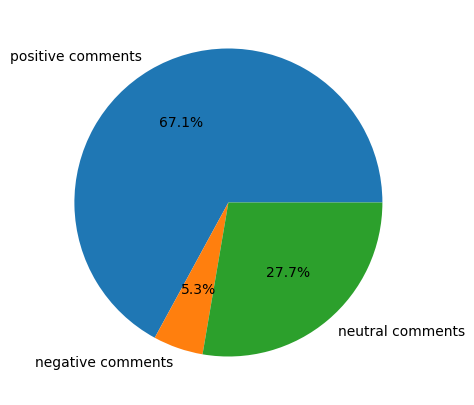

In [156]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,5))
ax.pie([summary['positive_comments_percentage'], summary['negative_comments_percentage'], summary['neutral_comments_percentage']],
       labels = ['positive comments', 'negative comments', 'neutral comments'], autopct='%1.1f%%')

In [157]:
def sample_comments_by_sentiment(analyzed_df, n_samples=10):
    """
    Sample n comments from each sentiment category (positive, negative, neutral)
    from the analyzed DataFrame.
    
    Parameters:
    analyzed_df (pandas.DataFrame): DataFrame with sentiment analysis results
    n_samples (int): Number of comments to sample from each category
    
    Returns:
    dict: Dictionary containing sampled comments for each sentiment category
    """
    # Flatten the comments_detail lists from all entries
    all_comments = []
    for details in analyzed_df['comments_detail']:
        all_comments.extend(details)
    
    # Convert to DataFrame for easier filtering
    comments_df = pd.DataFrame(all_comments)
    
    # Sample comments from each sentiment category
    samples = {}
    for sentiment in ['positive', 'negative', 'neutral']:
        category_comments = comments_df[comments_df['sentiment'] == sentiment]
        
        # If there are fewer comments than requested samples, take all available
        n_available = min(n_samples, len(category_comments))
        
        if n_available > 0:
            sampled = category_comments.sample(n=n_available, random_state=42)
            samples[sentiment] = sampled.to_dict('records')
        else:
            samples[sentiment] = []
            
    return samples

def print_sampled_comments(samples):
    """
    Pretty print the sampled comments.
    
    Parameters:
    samples (dict): Dictionary containing sampled comments
    """
    for sentiment in ['positive', 'negative', 'neutral']:
        print(f"\n=== {sentiment.upper()} COMMENTS ===")
        comments = samples[sentiment]
        
        if not comments:
            print(f"No {sentiment} comments found.")
            continue
            
        for i, comment_data in enumerate(comments, 1):
            print(f"\n{i}. Username: @{comment_data['username']}")
            print(f"   Comment: {comment_data['comment']}")
            print(f"   Score: {comment_data['score']:.3f}")

In [163]:
samples = sample_comments_by_sentiment(analysis)

In [164]:
samples

{'positive': [{'username': '@usmankhan2657',
   'comment': 'Thank you guru jiii',
   'score': 0.3612,
   'sentiment': 'positive'},
  {'username': '@krishnasahu5509',
   'comment': 'Jo bhi dislikers Ho \nKahi BhI \nDhundhlo tumhe isse best lecture Kahi nahi milega',
   'score': 0.6369,
   'sentiment': 'positive'},
  {'username': '@tousifahmed23',
   'comment': 'Basic pay 12750. Grade pay -4100. Joining date- 25.01.2019.  9-10 teacher.\n Dada anumanik salary koto hote pare. Please  dada ektu bolben.',
   'score': 0.128,
   'sentiment': 'positive'},
  {'username': '@sandeepjangir627',
   'comment': 'these videos are Awesome but not in a sequencial manner we are getting confused...please make proper playlist of topis with complete topocs. thankyou',
   'score': 0.3716,
   'sentiment': 'positive'},
  {'username': '@supriyakhot4995',
   'comment': 'this vedio is very nice and are all parts are to the point .',
   'score': 0.4754,
   'sentiment': 'positive'},
  {'username': '@prasadc.alande97

In [165]:
analysis.loc[0,'comments_detail']

[{'username': '@Ekeeda',
  'comment': 'Hello Friends \nWatch complete video series of subject Discrete Time Signals Processing only on Ekeeda Application. \nDownload Ekeeda application to get 1000 Studycoins and use it to access free courses.\nSteps to follow:-\n1. Download Ekeeda application from the link given below.\n2. Sign up or Log in to your account.\n3. You will get 1000 Studycoins worth Rs 1000.\n4. Add the courses to your cart.\n5. Select Study coins option to get free access.\nAndroid App : https://play.google.com/store/apps/details/?id=student.ekeeda.com.ekeeda_student \niOS App : https://apps.apple.com/in/app/ekeeda/id1442131224',
  'score': 0.891,
  'sentiment': 'positive'},
 {'username': '@kunalpawar2517',
  'comment': 'formula for Ap is wrong at 9:23. If I am not wrong it should be -20xlog(&p)',
  'score': -0.1396,
  'sentiment': 'neutral'},
 {'username': '@SaurabhKumar-tq8zn',
  'comment': '00:09 Chebyshev filter approximation has ripples in pass band and monotonicity 

In [166]:
comment

{'username': '@arifsir3452',
 'comment': 'Sir mujhe aapke yha coaching karna h',
 'score': 0.0,
 'sentiment': 'neutral'}

In [211]:
for group in samples:
    print(f'\n{group.upper()}:') 
    for comment in samples[group]:
        print('—',comment['score'],comment['comment'].encode("utf16", errors="surrogatepass").decode("utf16"))


POSITIVE:
— 0.3612 Thank you guru jiii
— 0.6369 Jo bhi dislikers Ho 
Kahi BhI 
Dhundhlo tumhe isse best lecture Kahi nahi milega
— 0.128 Basic pay 12750. Grade pay -4100. Joining date- 25.01.2019.  9-10 teacher.
 Dada anumanik salary koto hote pare. Please  dada ektu bolben.
— 0.3716 these videos are Awesome but not in a sequencial manner we are getting confused...please make proper playlist of topis with complete topocs. thankyou
— 0.4754 this vedio is very nice and are all parts are to the point .
— 0.6369 Simply best....
— 0.4084 Apko andaja hona chahie ki aapke pas h............... .........Knowledge :P
— 0.8074 Amazing series...its helping me a lot...please do continue this series and that left out parts :-)
— 0.0772 Bro plz make a video on govt central Universities which has BSC biotechnology courses
— 0.3612 i like all the videos of etoos education

NEGATIVE:
— -0.5423 hi sir mai medical imagine techology ke bad mpsc or upsc exam de sakti hu kya
— -0.3089 For some reason the JS

In [203]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords, words
import numpy as np

def generate_sentiment_wordclouds(analyzed_df, min_word_length=3, width=800, height=400):
    """
    Generate word clouds for positive, negative, and neutral comments,
    filtering for English words only.
    
    Parameters:
    analyzed_df (pandas.DataFrame): DataFrame with sentiment analysis results
    min_word_length (int): Minimum length of words to include
    width (int): Width of the word cloud image
    height (int): Height of the word cloud image
    
    Returns:
    tuple: (matplotlib figure, dict of WordCloud objects)
    """
    # Download required NLTK data
    try:
        nltk.data.find('corpora/stopwords')
        nltk.data.find('corpora/words')
    except LookupError:
        nltk.download('stopwords')
        nltk.download('words')
    
    # Get stop words and English words
    stop_words = set(stopwords.words('english'))
    english_words = set(words.words())
    
    # Add custom stop words relevant for comments
    custom_stop_words = {
        # 'like', 'just', 'video', 'gonna', 'would', 'could', 'should',
        # 'im', 'ive', 'thats', 'dont', 'doesnt', 'cant', 'wont',
        # 'http', 'https', 'www', 'com', 'youtube'
    }
    stop_words.update(custom_stop_words)
    
    def is_valid_english_word(word):
        """Check if word is valid English word or common internet slang"""
        # Common internet slang and abbreviations
        internet_slang = {
            'lol', 'omg', 'tbh', 'idk', 'fyi', 'imho', 'imo', 'btw',
            'asap', 'thx', 'pls', 'plz', 'ty', 'ok', 'omg', 'wow'
        }
        
        return (
            word.lower() in english_words or
            word.lower() in internet_slang or
            word.upper() in english_words  # Check for acronyms
        )
    
    def clean_text(text):
        """Clean and preprocess text"""
        # Convert to lowercase
        text = str(text).lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        # Remove user mentions
        text = re.sub(r'@\w+', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove punctuation and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    
    def get_word_frequencies(comments):
        """Get word frequencies from a list of comments, filtering for English words"""
        words = []
        for comment in comments:
            clean_comment = clean_text(comment)
            # Split into words and filter
            comment_words = [
                word for word in clean_comment.split()
                if len(word) >= min_word_length
                and word not in stop_words
                and is_valid_english_word(word)
            ]
            words.extend(comment_words)
        return Counter(words)
    
    # Separate comments by sentiment
    sentiment_comments = {'positive': [], 'negative': [], 'neutral': []}
    
    for details in analyzed_df['comments_detail']:
        for comment_data in details:
            sentiment_comments[comment_data['sentiment']].append(comment_data['comment'])
    
    # Generate word clouds
    wordclouds = {}
    fig, axes = plt.subplots(3, 1, figsize=(8, 16))
    # fig.suptitle('Word Clouds by Sentiment', fontsize=16)
    
    # Color schemes for each sentiment
    color_schemes = {
        'positive': 'BuGn',    # Yellow-Green for positive
        'negative': 'RdGy',    # Red-Gray for negative
        'neutral': 'Blues'     # Blues for neutral
    }
    
    for idx, (sentiment, comments) in enumerate(sentiment_comments.items()):
        if comments:
            # Get word frequencies
            frequencies = get_word_frequencies(comments)
            
            if frequencies:  # Check if we have any valid words
                # Generate word cloud
                wc = WordCloud(
                    width=width,
                    height=height,
                    background_color='white',
                    min_font_size=10,
                    max_font_size=150,
                    colormap=color_schemes[sentiment]
                )
                
                # Generate the word cloud
                wordcloud = wc.generate_from_frequencies(frequencies)
                wordclouds[sentiment] = wordcloud
                
                # Plot
                axes[idx].imshow(wordcloud, interpolation='bilinear')
                axes[idx].set_title(f'{sentiment.capitalize()} Comments')
                axes[idx].axis('off')
            else:
                axes[idx].text(0.5, 0.5, f'No valid English words\nin {sentiment} comments',
                             ha='center', va='center')
                axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f'No {sentiment} comments',
                         ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    
    return fig, wordclouds

def print_top_words(wordclouds, n_words=20):
    """
    Print the top N most frequent English words for each sentiment.
    
    Parameters:
    wordclouds (dict): Dictionary containing the WordCloud objects
    n_words (int): Number of top words to print
    """
    for sentiment, wordcloud in wordclouds.items():
        if wordcloud is not None:
            print(f"\n=== Top {n_words} English words in {sentiment.upper()} comments ===")
            word_freq = wordcloud.words_
            sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
            
            for word, freq in sorted_words[:n_words]:
                print(f"{word}: {freq:.2f}")

(<Figure size 800x1600 with 3 Axes>,
 {'positive': <wordcloud.wordcloud.WordCloud at 0x3184783e0>,
  'negative': <wordcloud.wordcloud.WordCloud at 0x3184772c0>,
  'neutral': <wordcloud.wordcloud.WordCloud at 0x31844a1e0>})

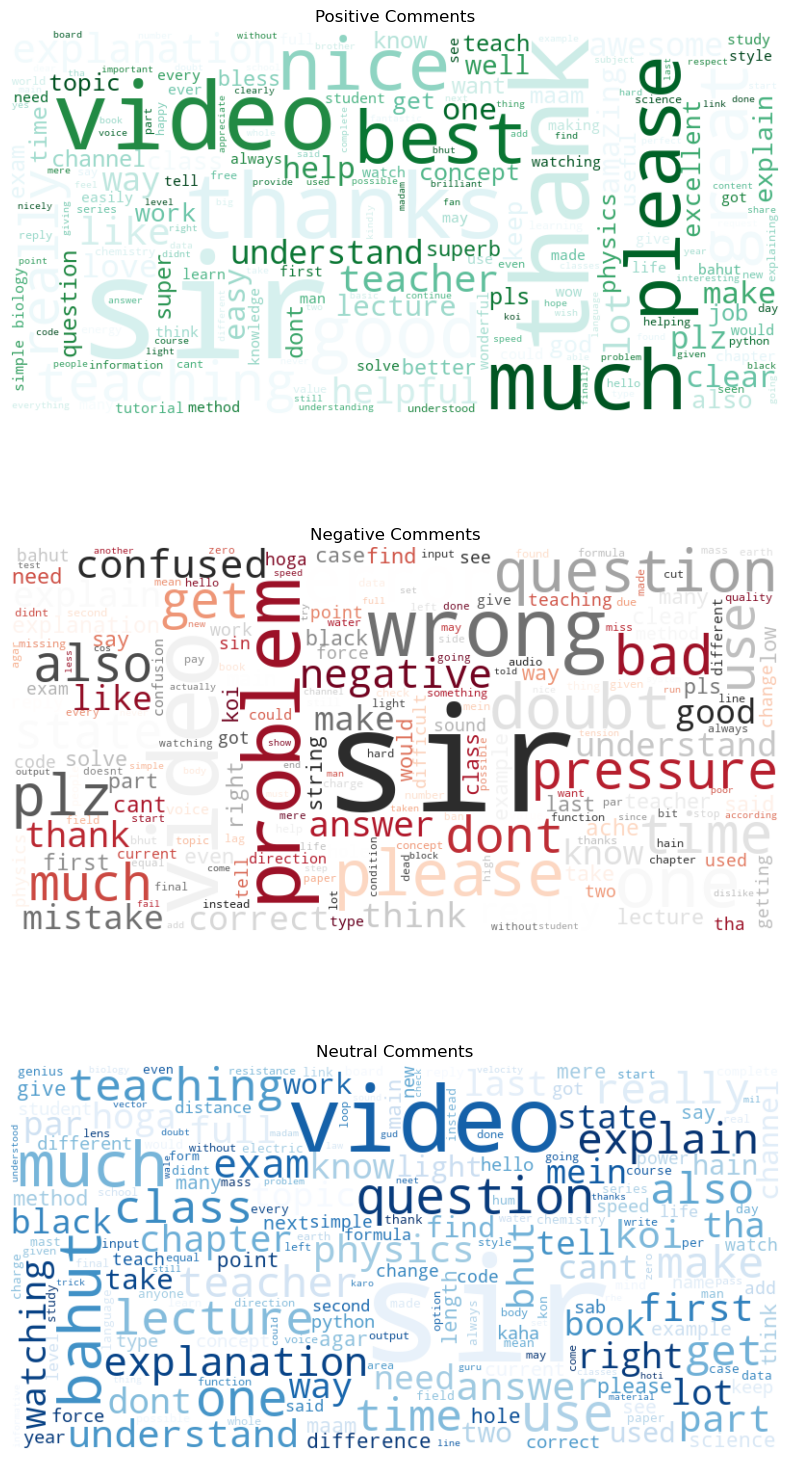

In [204]:
generate_sentiment_wordclouds(analysis)

In [209]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords, words as nltk_words
import numpy as np

def analyze_specific_words(analyzed_df, min_frequency=3, top_n=20):
    """
    Find words that are most specific to each sentiment category.
    
    Parameters:
    analyzed_df (pandas.DataFrame): DataFrame with sentiment analysis results
    min_frequency (int): Minimum frequency to consider a word
    top_n (int): Number of top specific words to return per sentiment
    
    Returns:
    dict: Dictionary containing specific words for each sentiment
    """
    # Download required NLTK data
    try:
        nltk.data.find('corpora/stopwords')
        nltk.data.find('corpora/words')
    except LookupError:
        nltk.download('stopwords')
        nltk.download('words')
    
    # Initialize NLTK resources
    stop_words = set(stopwords.words('english'))
    english_words = set(nltk_words.words())
    
    # Custom stop words
    custom_stop_words = {
        'like', 'just', 'video', 'gonna', 'would', 'could', 'should',
        'im', 'ive', 'thats', 'dont', 'doesnt', 'cant', 'wont',
        'http', 'https', 'www', 'com', 'youtube'
    }
    stop_words.update(custom_stop_words)
    
    def clean_text(text):
        """Clean and preprocess text"""
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        return ' '.join(text.split())
    
    def is_valid_english_word(word):
        """Check if word is valid English word or common internet slang"""
        internet_slang = {
            'lol', 'omg', 'tbh', 'idk', 'fyi', 'imho', 'imo', 'btw',
            'asap', 'thx', 'pls', 'plz', 'ty', 'ok', 'omg', 'wow'
        }
        return (
            word.lower() in english_words or
            word.lower() in internet_slang or
            word.upper() in english_words
        )
    
    # Collect words by sentiment
    sentiment_words = {
        'positive': Counter(),
        'negative': Counter(),
        'neutral': Counter()
    }
    
    # Count words in each sentiment category
    for details in analyzed_df['comments_detail']:
        for comment_data in details:
            sentiment = comment_data['sentiment']
            clean_comment = clean_text(comment_data['comment'])
            
            comment_words = [
                word for word in clean_comment.split()
                if len(word) >= 3
                and word not in stop_words
                and is_valid_english_word(word)
            ]
            
            sentiment_words[sentiment].update(comment_words)
    
    # Calculate specificity scores
    word_specificity = {}
    total_comments = {
        sentiment: sum(counter.values())
        for sentiment, counter in sentiment_words.items()
    }
    
    all_words = set()
    for counter in sentiment_words.values():
        all_words.update(counter.keys())
    
    for word in all_words:
        # Skip words that don't meet minimum frequency
        total_freq = sum(counter[word] for counter in sentiment_words.values())
        if total_freq < min_frequency:
            continue
        
        # Calculate specificity for each sentiment
        for sentiment in sentiment_words.keys():
            # Frequency in this sentiment
            freq_in_sentiment = sentiment_words[sentiment][word]
            
            # Frequency in other sentiments
            freq_in_others = sum(
                counter[word] 
                for s, counter in sentiment_words.items() 
                if s != sentiment
            )
            
            # Calculate specificity score
            if freq_in_sentiment > 0:
                normalized_freq_in_sentiment = freq_in_sentiment / total_comments[sentiment]
                normalized_freq_in_others = (freq_in_others / sum(
                    total_comments[s] for s in sentiment_words.keys() if s != sentiment
                )) if freq_in_others > 0 else 0
                
                specificity = normalized_freq_in_sentiment
                if normalized_freq_in_others > 0:
                    specificity = normalized_freq_in_sentiment / normalized_freq_in_others
                
                if word not in word_specificity:
                    word_specificity[word] = {}
                word_specificity[word][sentiment] = (specificity, freq_in_sentiment)
    
    # Get most specific words for each sentiment
    specific_words = {}
    for sentiment in sentiment_words.keys():
        # Get words with specificity scores for this sentiment
        sentiment_scores = [
            (word, scores[sentiment][0], scores[sentiment][1])
            for word, scores in word_specificity.items()
            if sentiment in scores
        ]
        
        # Sort by specificity score
        specific_words[sentiment] = sorted(
            sentiment_scores,
            key=lambda x: (x[1], x[2]),  # Sort by specificity, then frequency
            reverse=True
        )[:top_n]
    
    return specific_words

def print_specific_words(specific_words):
    """
    Print the most specific words for each sentiment category.
    
    Parameters:
    specific_words (dict): Dictionary containing specific words for each sentiment
    """
    for sentiment, words in specific_words.items():
        print(f"\n=== Most Specific Words for {sentiment.upper()} Comments ===")
        print(f"{'Word':<15} {'Specificity':<12} {'Frequency':<10}")
        print("-" * 37)
        
        for word, specificity, frequency in words:
            print(f"{word:<15} {specificity:>11.2f} {frequency:>9}")

In [210]:
analyze_specific_words(analysis)

{'positive': [('bless', 142.38017054555732, 1284),
  ('truly', 63.538814425704324, 191),
  ('beautiful', 61.87549467634033, 372),
  ('wonderful', 59.87951097710356, 900),
  ('love', 46.426580844247624, 3489),
  ('glad', 41.91565768397248, 126),
  ('fantastic', 40.0860059596721, 482),
  ('easiest', 38.589018185244505, 116),
  ('interesting', 36.593034486007724, 660),
  ('effective', 36.426702511071326, 219),
  ('outstanding', 35.816818602971196, 323),
  ('sweet', 35.59504263638933, 107),
  ('beautifully', 34.92971473664374, 105),
  ('valuable', 33.59905893715255, 202),
  ('appreciate', 32.601067087534155, 490),
  ('enjoy', 28.609099689060585, 86),
  ('brilliant', 28.542566899086026, 429),
  ('god', 28.291556827818365, 1871),
  ('wow', 28.110103764251388, 1014),
  ('blessed', 27.94377178931499, 168)],
 'negative': [('irreversible', 128.22074944071588, 11),
  ('illegal', 93.25145413870246, 8),
  ('thief', 87.42323825503355, 15),
  ('sin', 86.07826535880227, 96),
  ('dirty', 81.59502237136